# Centroid alignment using Xopt/BAX

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.expected_improvement import ExpectedImprovementGenerator

from xopt.evaluator import Evaluator

import time
import numpy as np
import random

# Pathwise sampling for Linear Product Kernel

In [2]:
import copy
import math

def draw_poly_kernel_prior_paths(
    poly_kernel, n_samples
):  # poly_kernel is a scaled polynomial kernel
    c = poly_kernel.offset
    degree = poly_kernel.power
    ws = torch.randn(size=[n_samples, 1, degree + 1], device=c.device)

    def paths(xs):
        if (
            len(xs.shape) == 2 and xs.shape[1] == 1
        ):  # xs must be n_samples x npoints x 1 dim
            xs = xs.repeat(n_samples, 1, 1)  # duplicate over batch (sample) dim

        coeffs = [math.comb(degree, i) for i in range(degree + 1)]
        X = torch.concat(
            [
                (coeff * c.pow(i)).sqrt() * xs.pow(degree - i)
                for i, coeff in enumerate(coeffs)
            ],
            dim=2,
        )
        W = ws.repeat(1, xs.shape[1], 1)  # ws is n_samples x 1 x 3 dim

        phis = W * X
        return torch.sum(phis, dim=-1)  # result tensor is shape n_samples x npoints

    return paths

def draw_linear_product_kernel_prior_paths(model, n_samples):
    ndim = model.train_inputs[0].shape[1]

    outputscale = copy.copy(model.covar_module.outputscale.detach())
    kernels = []
    dims = []

    for i in range(len(model.covar_module.base_kernel.kernels)):
        lin_kernel = copy.deepcopy(model.covar_module.base_kernel.kernels[i])
        kernels += [lin_kernel]
        dims += [lin_kernel.active_dims]

    lin_prior_paths = [
        draw_poly_kernel_prior_paths(kernel, n_samples) for kernel in kernels
    ]

    def linear_product_kernel_prior_paths(xs):
        ys_lin = []
        for i in range(len(lin_prior_paths)):
            xs_lin = torch.index_select(xs, dim=-1, index=dims[i]).float()
            ys_lin += [lin_prior_paths[i](xs_lin)]
        output = 1.0
        for ys in ys_lin:
            output *= ys
        return (outputscale.sqrt() * output).double()

    return linear_product_kernel_prior_paths

def draw_linear_product_kernel_post_paths(model, n_samples, cpu=True):
    linear_product_kernel_prior_paths = draw_linear_product_kernel_prior_paths(
        model, n_samples=n_samples
    )

    train_x = model.train_inputs[0]

    train_y = model.train_targets.reshape(-1, 1)

    train_y = train_y - model.mean_module(train_x).reshape(train_y.shape)

    Knn = model.covar_module(train_x, train_x)

    sigma = torch.sqrt(model.likelihood.noise[0])

    K = Knn + sigma**2 * torch.eye(Knn.shape[0])

    prior_residual = train_y.repeat(n_samples, 1, 1).reshape(
        n_samples, -1
    ) - linear_product_kernel_prior_paths(train_x)
    prior_residual -= sigma * torch.randn_like(prior_residual)

    Lnn = torch.cholesky(K.to_dense())
    batched_lnn = torch.stack([Lnn] * n_samples)
    batched_lnnt = torch.stack([Lnn.T] * n_samples)

    vbar = torch.linalg.solve(batched_lnn, prior_residual)
    v = torch.linalg.solve(batched_lnnt, vbar)
    v = v.reshape(-1, 1)

    v = v.reshape(n_samples, -1, 1)
    v_t = v.transpose(1, 2)

    def post_paths(xs):
        if model.input_transform is not None:
            xs = model.input_transform(xs)

        K_update = model.covar_module(train_x, xs.double())

        update = torch.matmul(v_t, K_update)
        update = update.reshape(n_samples, -1)

        prior = linear_product_kernel_prior_paths(xs)

        post = prior + update + model.mean_module(xs)
        if model.outcome_transform is not None:
            post = model.outcome_transform.untransform(post)[0]

        return post

    post_paths.n_samples = n_samples

    return post_paths

# Alignment Algorithm

In [3]:
from xopt.generators.bayesian.bax.algorithms import Algorithm
from abc import ABC
from pydantic import Field
from scipy.optimize import minimize
from torch import Tensor
from botorch.models.model import Model, ModelList
from typing import Dict, Tuple, Union

def unif_random_sample_domain(n_samples, domain):
    ndim = len(domain)

    # uniform sample, rescaled, and shifted to cover the domain
    x_samples = torch.rand(n_samples, ndim) * torch.tensor(
        [bounds[1] - bounds[0] for bounds in domain]
    ) + torch.tensor([bounds[0] for bounds in domain])

    return x_samples

class ScipyBeamAlignment(Algorithm, ABC):
    name = "ScipyBeamAlignment"
    meas_dims: Union[int, list[int]] = Field(
        description="list of indeces identifying the measurement quad dimensions in the model"
    )
    bpm_names : list[str] = Field(
        description="names of beam position monitors used to measure alignment")

    @property
    def model_names_ordered(self) -> list:  
        # get observable model names in the order they appear in the model (ModelList)
        return [name for name in self.bpm_names]
    
    def get_execution_paths(
        self, model: Model, bounds: Tensor
    ) -> Tuple[Tensor, Tensor, Dict]:
        """get execution paths that minimize the objective function"""

        x_stars_all, xs, ys, post_paths_cpu = self.get_sample_optimal_tuning_configs(
            model.models[0], bounds, cpu=False
        )

        xs_exe = xs
        ys_exe = ys.reshape(*ys.shape, 1)

        results_dict = {
            "xs_exe": xs_exe,
            "ys_exe": ys_exe,
            "X_stars": x_stars_all,
            "post_paths_cpu": post_paths_cpu,
        }

        return xs_exe, ys_exe, results_dict

    def get_sample_optimal_tuning_configs(
        self, model: Model, bounds: Tensor, verbose=False, cpu=False
    ):
        meas_scans = torch.index_select(
            bounds.T, dim=0, index=torch.tensor(self.meas_dims)
        )
        ndim = bounds.shape[1]
        tuning_dims = [i for i in range(ndim) if i not in self.meas_dims]
        tuning_domain = torch.index_select(
            bounds.T, dim=0, index=torch.tensor(tuning_dims)
        )

        device = torch.tensor(1).device
        torch.set_default_tensor_type("torch.DoubleTensor")

        cpu_model = copy.deepcopy(model).cpu()

        post_paths_cpu = draw_linear_product_kernel_post_paths(
            cpu_model, n_samples=self.n_samples
        )

        xs_tuning_init = unif_random_sample_domain(
            self.n_samples, tuning_domain
        ).double()

        x_tuning_init = xs_tuning_init.flatten()

        # minimize
        def target_func_for_scipy(x_tuning_flat):
            return (
                self.sum_samplewise_misalignment_flat_x(
                    post_paths_cpu,
                    torch.tensor(x_tuning_flat),
                    self.meas_dims,
                    meas_scans.cpu(),
                )
                .detach()
                .cpu()
                .numpy()
            )

        def target_func_for_torch(x_tuning_flat):
            return self.sum_samplewise_misalignment_flat_x(
                post_paths_cpu, x_tuning_flat, self.meas_dims, meas_scans.cpu()
            )

        def target_jac(x):
            return (
                torch.autograd.functional.jacobian(
                    target_func_for_torch, torch.tensor(x)
                )
                .detach()
                .cpu()
                .numpy()
            )

        res = minimize(
            target_func_for_scipy,
            x_tuning_init.detach().cpu().numpy(),
            jac=target_jac,
            bounds=tuning_domain.repeat(self.n_samples, 1).detach().cpu().numpy(),
            options={"eps": 1e-03},
        )
        if verbose:
            print(
                "ScipyBeamAlignment evaluated",
                self.n_samples,
                "(pathwise) posterior samples",
                res.nfev,
                "times in get_sample_optimal_tuning_configs().",
            )

            print(
                "ScipyBeamAlignment evaluated",
                self.n_samples,
                "(pathwise) posterior sample jacobians",
                res.njev,
                "times in get_sample_optimal_tuning_configs().",
            )

            print(
                "ScipyBeamAlignment took",
                res.nit,
                "steps in get_sample_optimal_tuning_configs().",
            )

        x_stars_flat = torch.tensor(res.x)

        x_stars_all = x_stars_flat.reshape(
            self.n_samples, -1
        )  # each row represents its respective sample's optimal tuning config

        misalignment, xs, ys = self.post_path_misalignment(
            post_paths_cpu,
            x_stars_all,  # n x d tensor
            self.meas_dims,  # list of integers
            meas_scans.cpu(),  # tensor of measurement device(s) scan inputs, shape: len(meas_dims) x 2
            samplewise=True,
        )

        if device.type == "cuda":
            torch.set_default_tensor_type("torch.cuda.DoubleTensor")

        if cpu:
            return x_stars_all, xs, ys, post_paths_cpu  # x_stars should still be on cpu
        else:
            return x_stars_all.to(device), xs.to(device), ys.to(device), post_paths_cpu
        
    def post_path_misalignment(
        self,
        post_paths,
        x_tuning,  # n x d tensor
        meas_dims,  # list of integers
        meas_scans,  # tensor of measurement device(s) scan inputs, shape: len(meas_dims) x 2
        samplewise=False,
    ):
        """
        A function that computes the beam misalignment(s) through a set of measurement quadrupoles
        from a set of pathwise samples taken from a SingleTaskGP model of the beam centroid position with
        respect to some tuning devices and some measurement quadrupoles.

        arguments:
            post_paths: a pathwise posterior sample from a SingleTaskGP model of the beam centroid
                        position (assumes Linear ProductKernel)
            x_tuning: a tensor of shape (n_samples x n_tuning_dims) where the nth row defines a point in
                        tuning-parameter space at which to evaluate the misalignment of the nth
                        posterior pathwise sample given by post_paths
            meas_dims: the dimension indeces of our model that describe the quadrupole measurement devices
            meas_scans: a tensor of measurement scan inputs, shape len(meas_dims) x 2, where the nth row
                        contains two input scan values for the nth measurement quadrupole
            samplewise: boolean. Set to False if you want to evaluate the misalignment for every point on
                        every sample. If set to True, the misalignment for the nth sample (given by post_paths)
                        will only be evaluated at the nth point (given by x_tuning). If samplewise is set to
                        True, x_tuning must be shape n_samples x n_tuning_dims

         returns:
             misalignment: the sum of the squared slopes of the beam centroid model output with respect to the
                             measurement quads
             xs: the virtual scan inputs
             ys: the virtual scan outputs (beam centroid positions)

        NOTE: meas scans only needs to have 2 values for each device because it is expected that post_paths
                are produced from a SingleTaskGP with Linear ProductKernel (i.e. post_paths should have
                linear output for each dimension).
        """
        n_steps_meas_scan = 1 + len(meas_dims)
        n_tuning_configs = x_tuning.shape[0]

        # construct measurement scan inputs
        xs = torch.repeat_interleave(x_tuning, n_steps_meas_scan, dim=0)

        for i in range(len(meas_dims)):
            meas_dim = meas_dims[i]
            meas_scan = meas_scans[i]
            full_scan_column = meas_scan[0].repeat(n_steps_meas_scan, 1)
            full_scan_column[i + 1, 0] = meas_scan[1]
            full_scan_column_repeated = full_scan_column.repeat(n_tuning_configs, 1)

            xs = torch.cat(
                (xs[:, :meas_dim], full_scan_column_repeated, xs[:, meas_dim:]), dim=1
            )

        if samplewise:
            xs = xs.reshape(n_tuning_configs, n_steps_meas_scan, -1)

        ys = post_paths(xs)
        ys = ys.reshape(-1, n_steps_meas_scan)

        rise = ys[:, 1:] - ys[:, 0].reshape(-1, 1)
        run = (meas_scans[:, 1] - meas_scans[:, 0]).T.repeat(ys.shape[0], 1)
        slope = rise / run

        misalignment = slope.pow(2).sum(dim=1)

        if not samplewise:
            ys = ys.reshape(-1, n_tuning_configs, n_steps_meas_scan)
            misalignment = misalignment.reshape(-1, n_tuning_configs)

        return misalignment, xs, ys
    
    def sum_samplewise_misalignment_flat_x(
        self, post_paths, x_tuning_flat, meas_dims, meas_scans
    ):
        """
        A wrapper function that computes the sum of the samplewise misalignments for more convenient
        minimization with scipy.

        arguments:
            Same as post_path_misalignment() EXCEPT:

            x_tuning_flat: a FLATTENED tensor formerly of shape (n_samples x ndim) where the nth
                            row defines a point in tuning-parameter space at which to evaluate the
                            misalignment of the nth posterior pathwise sample given by post_paths

            NOTE: x_tuning_flat must be 1d (flattened) so the output of this function can be minimized
                    with scipy minimization routines (that expect a 1d vector of inputs)
            NOTE: samplewise is set to True to avoid unncessary computation during simultaneous minimization
                    of the pathwise misalignments.
        """

        x_tuning = x_tuning_flat.double().reshape(post_paths.n_samples, -1)

        return torch.sum(
            self.post_path_misalignment(
                post_paths, x_tuning, meas_dims, meas_scans, samplewise=True
            )[0]
        )

# Notebook settings

In [4]:
noise = False #whether to add noise to the ground-truth beam size function outputs
n_obs_init = 3 #number of random initial observations for GP model
n_samples = 100 #number of posterior samples for BAX
rand_seed = 0

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [5]:
# define test functions
var_names = ['x0', 'x1']

def centroid_position_at_screen(x):
    r0 = 0.0
    cpas = (r0 + x[:,0]) + (r0 + x[:,0])*x[:,1]
    
#     return cpas * (1. + .1*torch.randn_like(cpas))
    return cpas 

def test_func(input_dict):
    x0 = torch.tensor(input_dict['x0']).reshape(-1,1)
    x1 = torch.tensor(input_dict['x1']).reshape(-1,1)
    x = torch.cat((x0, x1), dim=1)
    return {'y': float(centroid_position_at_screen(x).squeeze().cpu().numpy())}

# Construct vocs

In [6]:
variables = {var_name: [-2,2] for var_name in var_names}

#construct vocs
vocs = VOCS(
    variables = variables,
    objectives = {'y':"MINIMIZE"}
)

print('variable_names =', vocs.variable_names)
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
domain =
 [[-2.  2.]
 [-2.  2.]]


# Prepare generator.
In this example, we use a specialty covariance module (Linear ProductKernel) for our beam size model.

In [7]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator

# from emitopt.algorithms import ScipyBeamAlignment

# prepare custom covariance module
# covar_module = PolynomialKernel(power=1)
covar_module = PolynomialKernel(power=1, active_dims=[0]) * PolynomialKernel(power=1, active_dims=[1])
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'y': scaled_covar_module}
# covar_module_dict = {}
model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

algo = ScipyBeamAlignment(meas_dims=[1], n_samples=n_samples, bpm_names=['y'])

# Construct generator, evaluator, Xopt objects

In [8]:
#construct BAX generator
generator = BaxGenerator(vocs=vocs, gp_constructor=model_constructor, algorithm=algo)
# generator = ExpectedImprovementGenerator(vocs, generator_options)

#construct evaluator
evaluator = Evaluator(function=test_func)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [9]:
optimizer.random_evaluate(n_obs_init)

,x0,x1,y,xopt_runtime,xopt_error
0,-0.195254,-0.179533,-0.160200,0.000416,False
1,-0.860757,0.305381,-1.123616,0.000095,False
2,-0.411054,-0.583576,-0.171172,0.000087,False


In [10]:
optimizer.data

,x0,x1,y,xopt_runtime,xopt_error
0,-0.195254,-0.179533,-0.160200,0.000416,False
1,-0.860757,0.305381,-1.123616,0.000095,False
2,-0.411054,-0.583576,-0.171172,0.000087,False


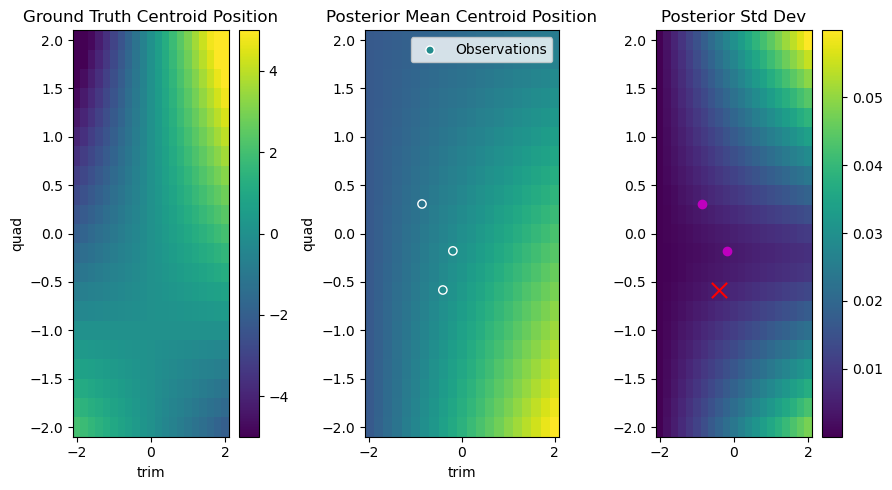

In [11]:
beam_centroid_model = optimizer.generator.train_model().models[0]

ls = torch.linspace(-2,2,21)
x0, x1 = torch.meshgrid(ls, ls)
xmesh_serialized = torch.cat((x0.reshape(-1,1), x1.reshape(-1,1)), dim=1)
ymesh_model = beam_centroid_model.posterior(xmesh_serialized).mean.reshape(21,21).detach()
ymesh_model_var = beam_centroid_model.posterior(xmesh_serialized).variance.reshape(21,21).detach()
ymesh_gt = centroid_position_at_screen(xmesh_serialized).reshape(21,21).detach()

fig, axs = plt.subplots(1,3)
fig.set_size_inches(9,5)

ax = axs[0]
c = ax.pcolormesh(x0, x1, ymesh_gt, vmin=-5, vmax=5)
fig.colorbar(c)
ax.set_xlabel('trim')
ax.set_ylabel('quad')
ax.set_title('Ground Truth Centroid Position')

ax = axs[1]
ax.pcolormesh(x0, x1, ymesh_model, vmin=-5, vmax=5)
ax.set_xlabel('trim')
ax.set_ylabel('quad')
ax.set_title('Posterior Mean Centroid Position')
ax.scatter(optimizer.data['x0'], optimizer.data['x1'], c=optimizer.data['y'],
           vmin=-5, vmax=5, edgecolors='w', label='Observations')
ax.legend()

ax = axs[2]
c = ax.pcolormesh(x0, x1, ymesh_model_var.sqrt())
fig.colorbar(c)

# for x_star in X_stars:
#     ax.axvline(float(x_star), ymax=0.1, c='r')
    
ax.scatter(optimizer.data['x0'][:-1], optimizer.data['x1'][:-1], c='m', label='Observations')
ax.scatter(optimizer.data['x0'][-1:], optimizer.data['x1'][-1:], c='r', marker='x', s=120)
ax.set_title('Posterior Std Dev')

plt.tight_layout()



Iteration 0 



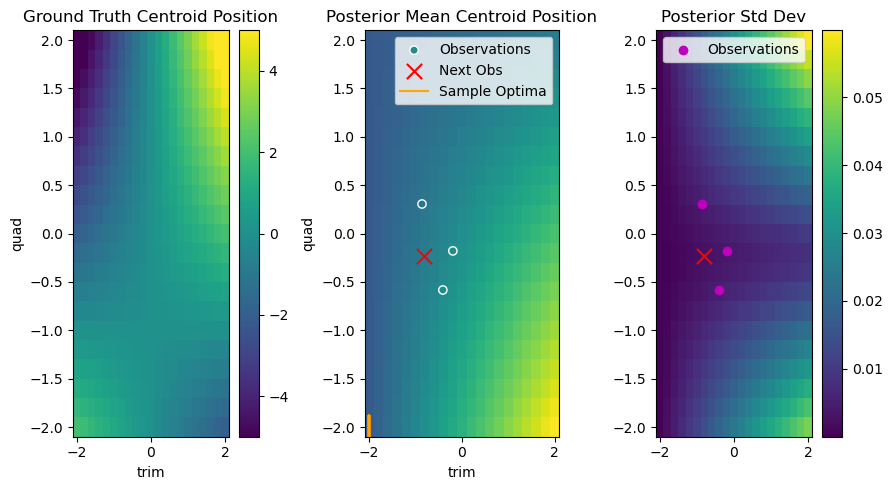

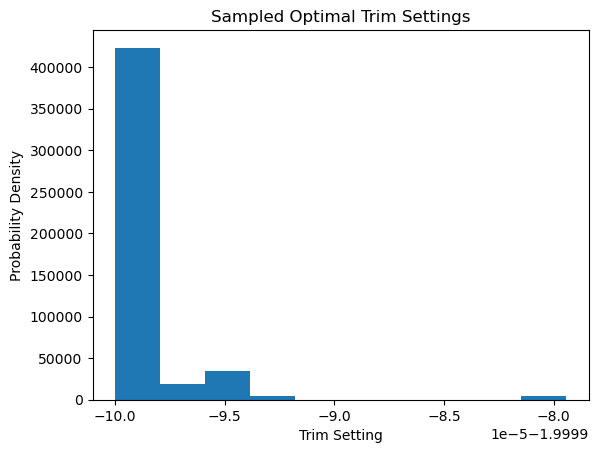



Iteration 1 



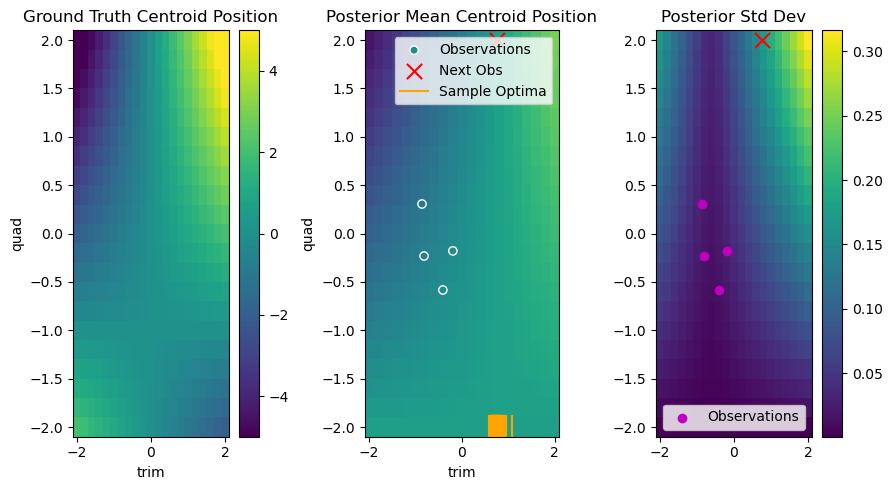

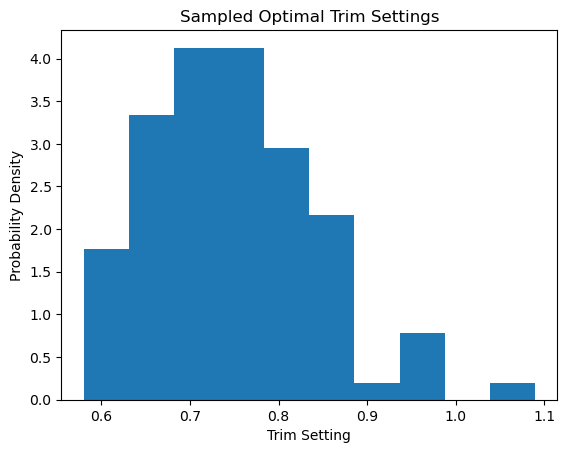



Iteration 2 



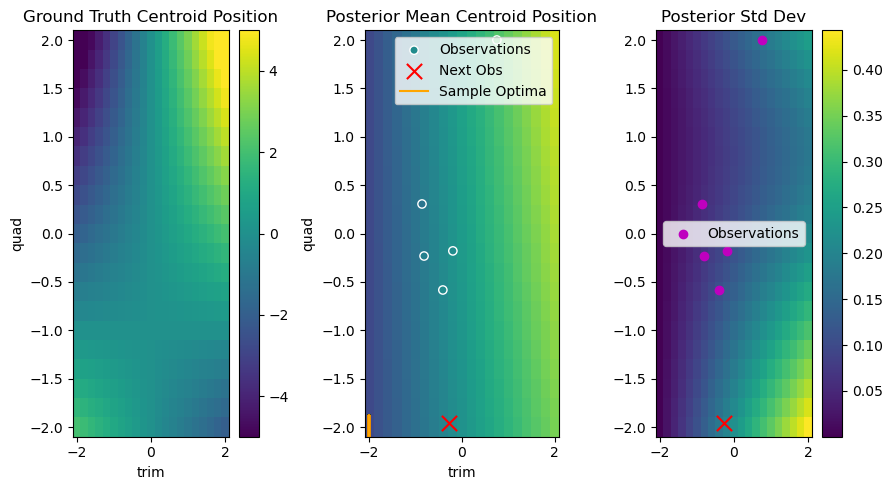

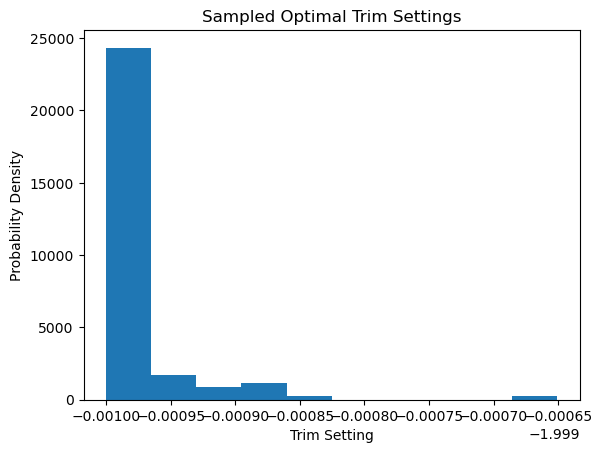



Iteration 3 



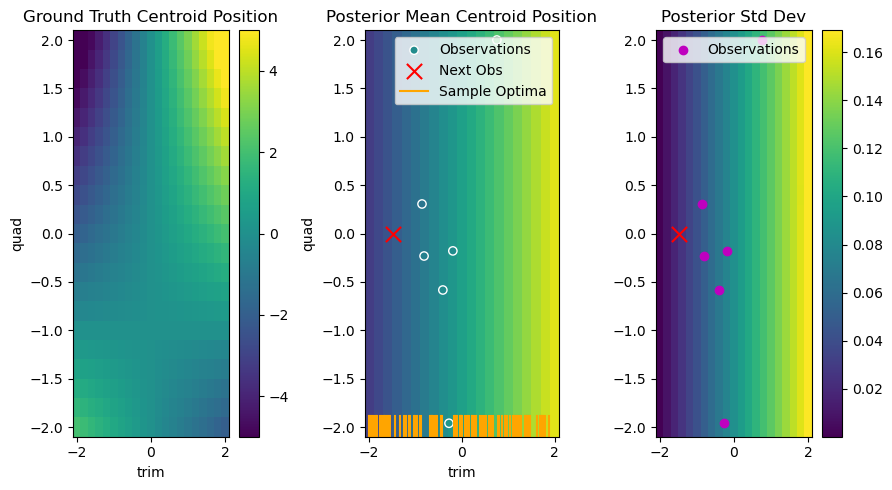

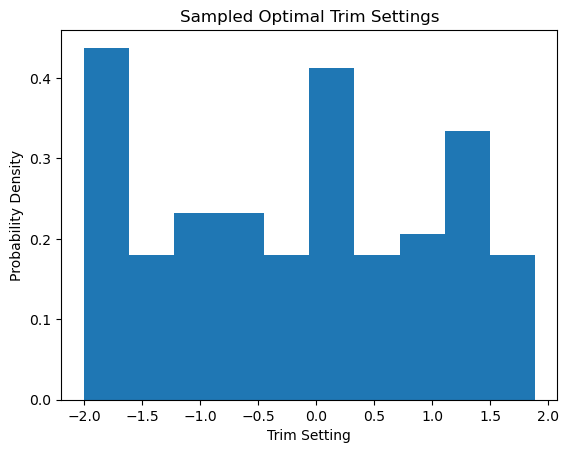



Iteration 4 



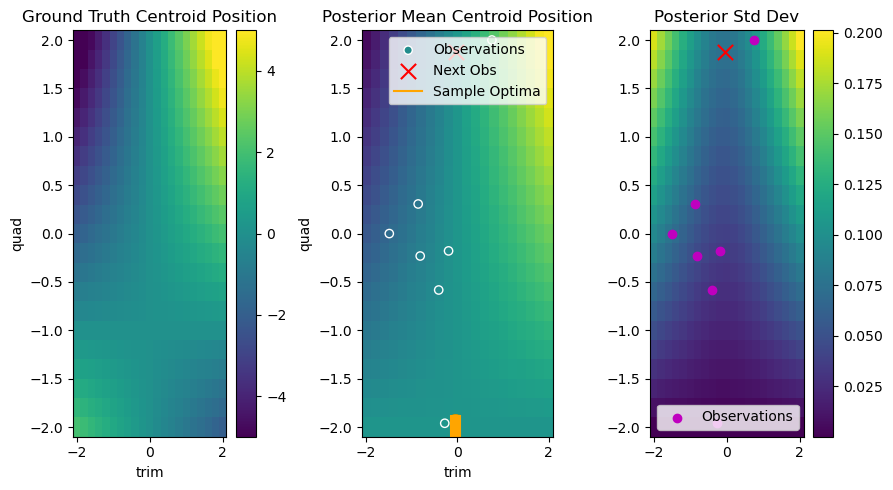

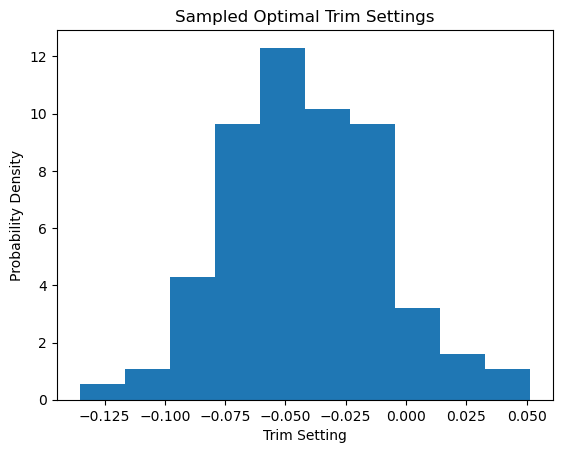



Iteration 5 



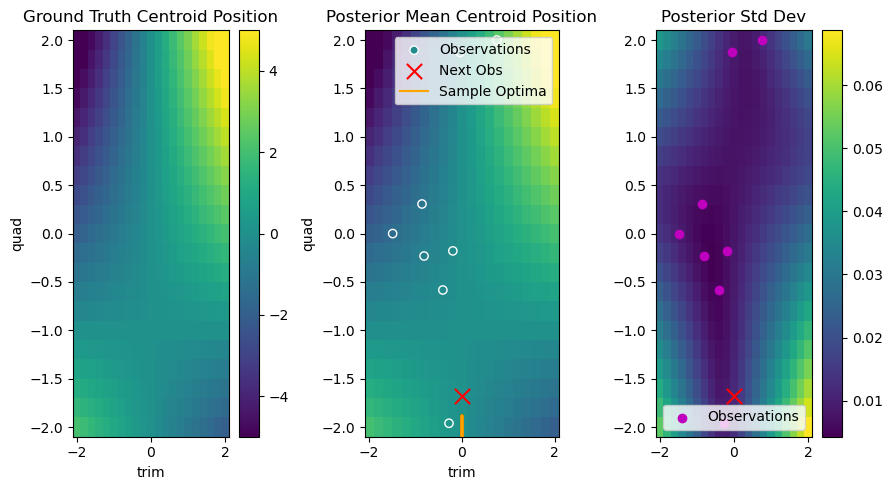

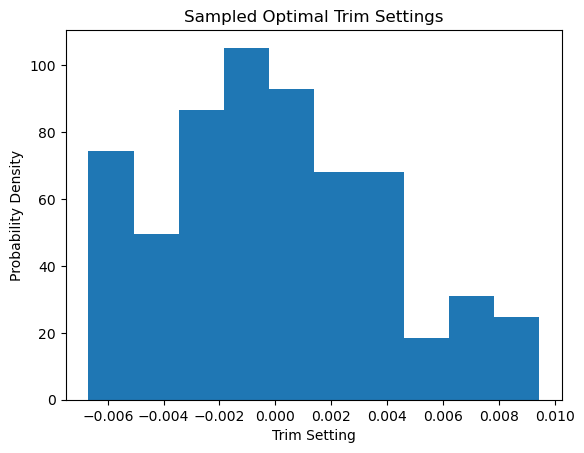



Iteration 6 



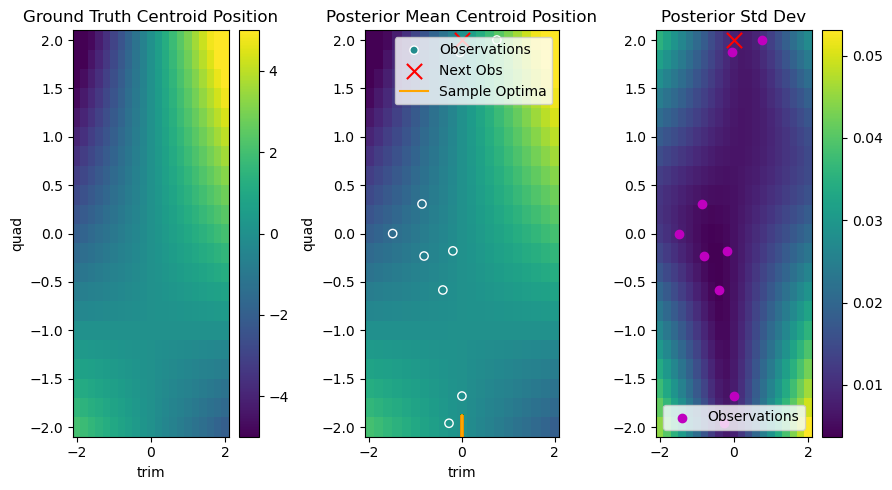

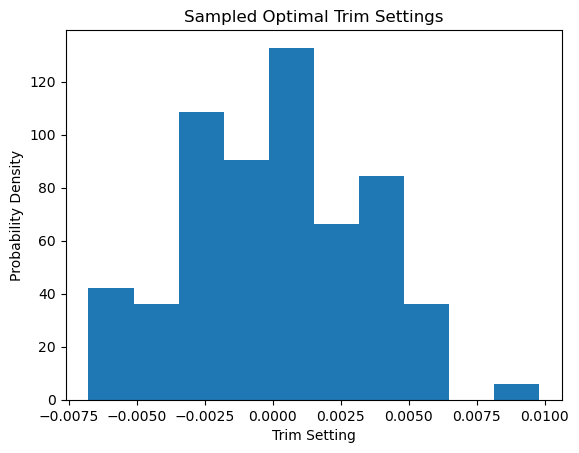



Iteration 7 



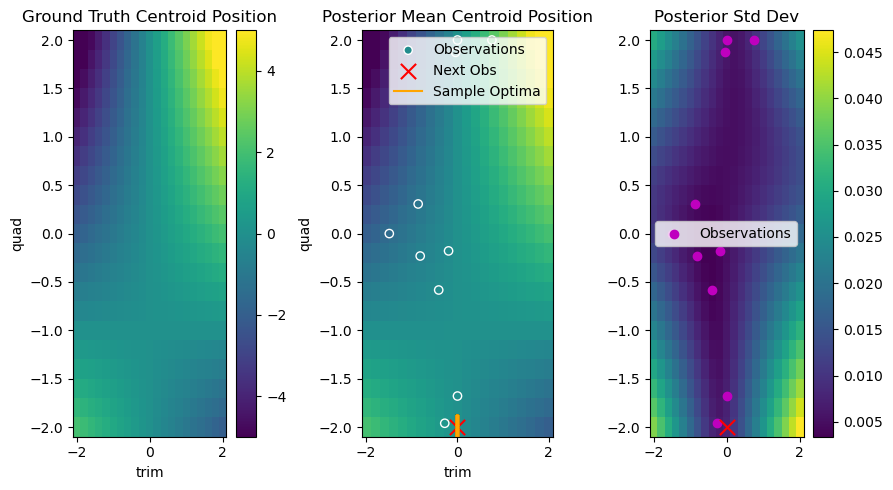

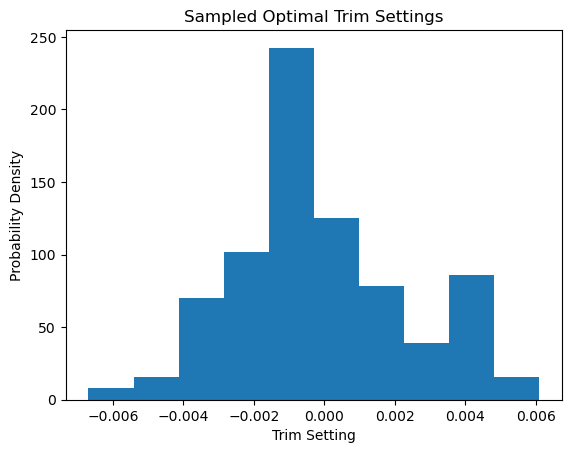



Iteration 8 



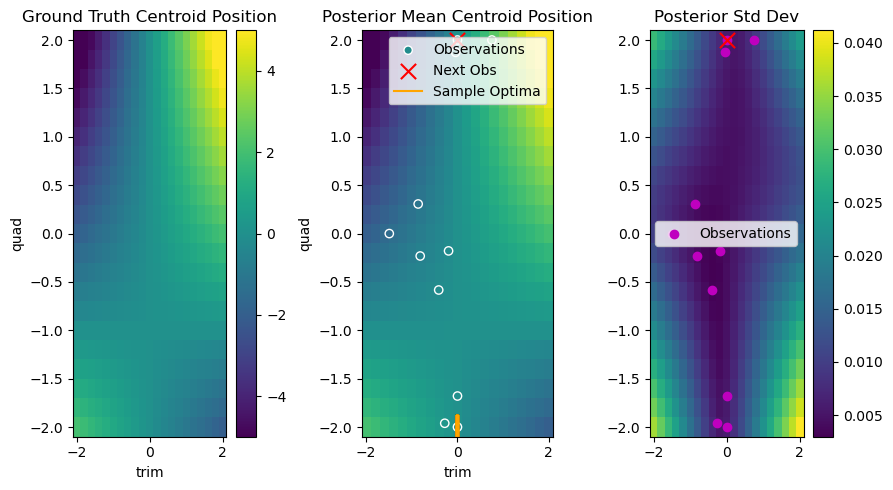

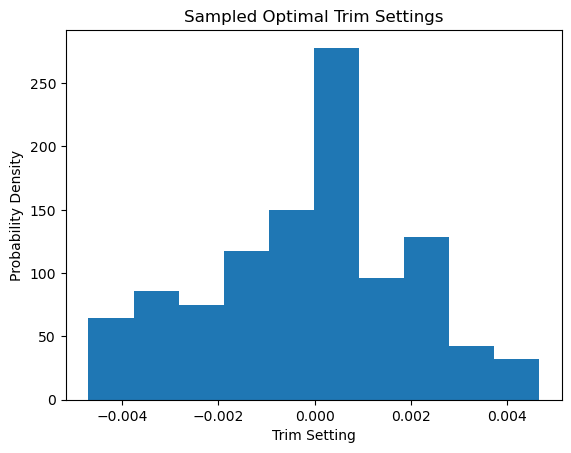



Iteration 9 



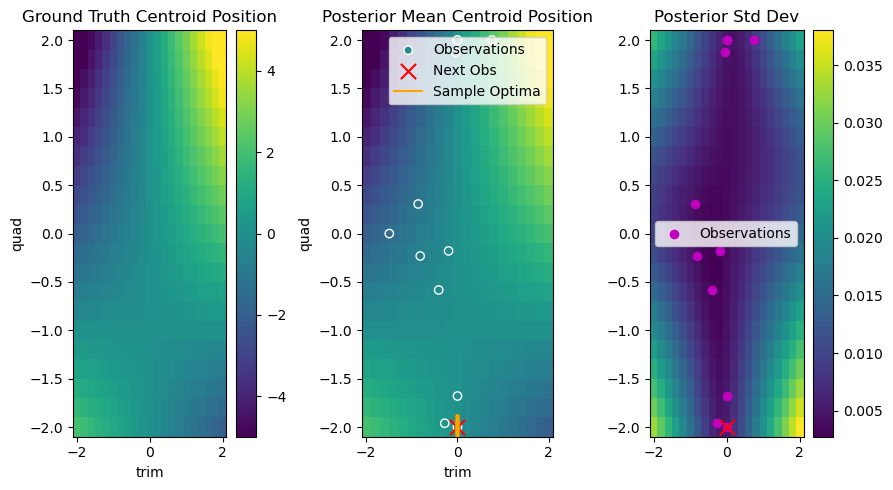

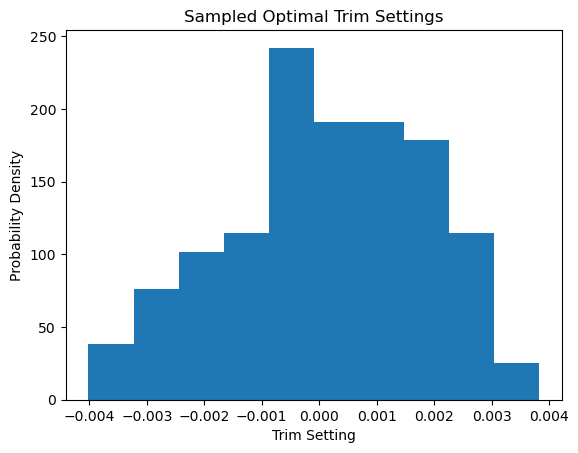

In [12]:
for i in range(10):
    print('\n\nIteration', i, '\n')
    optimizer.step()
#     X_stars = optimizer.generator.algo_results['X_stars']

    beam_centroid_model = optimizer.generator.model.models[0]

    ls = torch.linspace(-2,2,21)
    x0, x1 = torch.meshgrid(ls, ls)
    xmesh_serialized = torch.cat((x0.reshape(-1,1), x1.reshape(-1,1)), dim=1)
    ymesh_model = beam_centroid_model.posterior(xmesh_serialized).mean.reshape(21,21).detach()
    ymesh_model_var = beam_centroid_model.posterior(xmesh_serialized).variance.reshape(21,21).detach()
    ymesh_gt = centroid_position_at_screen(xmesh_serialized).reshape(21,21).detach()

    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(9,5)

    ax = axs[0]
    c = ax.pcolormesh(x0, x1, ymesh_gt, vmin=-5, vmax=5)
    fig.colorbar(c)
    ax.set_xlabel('trim')
    ax.set_ylabel('quad')
    ax.set_title('Ground Truth Centroid Position')

    ax = axs[1]
    ax.pcolormesh(x0, x1, ymesh_model, vmin=-5, vmax=5)
    ax.set_xlabel('trim')
    ax.set_ylabel('quad')
    ax.set_title('Posterior Mean Centroid Position')
    ax.scatter(optimizer.data['x0'][:-1], optimizer.data['x1'][:-1], c=optimizer.data['y'][:-1], 
               vmin=-5, vmax=5, edgecolors='w', label='Observations')
    ax.scatter(optimizer.data['x0'][-1:], optimizer.data['x1'][-1:], c='r', 
               marker='x', s=120, label='Next Obs')

    X_stars = optimizer.generator.algorithm_results['X_stars']
    
    ax.axvline(X_stars.flatten()[0], c='orange', ymax=0.05, label='Sample Optima')
    for x_star in X_stars.flatten()[1:]:
        ax.axvline(x_star, c='orange', ymax=0.05)
    
    ax.legend()
    
    ax = axs[2]
    c = ax.pcolormesh(x0, x1, ymesh_model_var.sqrt())
    fig.colorbar(c)

    # for x_star in X_stars:
    #     ax.axvline(float(x_star), ymax=0.1, c='r')

    ax.scatter(optimizer.data['x0'][:-1], optimizer.data['x1'][:-1], c='m', label='Observations')
    ax.scatter(optimizer.data['x0'][-1:], optimizer.data['x1'][-1:], c='r', marker='x', s=120)
    ax.set_title('Posterior Std Dev')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    plt.hist(X_stars.flatten(), density=True)
    plt.title('Sampled Optimal Trim Settings')
    plt.xlabel('Trim Setting')
    plt.ylabel('Probability Density')
    plt.show()

In [13]:
optimizer.data

,x0,x1,y,xopt_runtime,xopt_error
0,-0.195254,-0.179533,-0.160200,0.000416,False
1,-0.860757,0.305381,-1.123616,0.000095,False
2,-0.411054,-0.583576,-0.171172,0.000087,False
3,-0.816115,-0.232348,-0.626492,0.000106,False
4,0.753831,2.000000,2.261492,0.000104,False
5,-0.278652,-1.960832,0.267737,0.000097,False
6,-1.493189,-0.000446,-1.492522,0.000099,False
7,-0.042009,1.872375,-0.120667,0.000116,False
8,0.000075,-1.679354,-0.000051,0.000098,False
9,0.000125,2.000000,0.000374,0.000101,False
